In [31]:
## Importing necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, roc_auc_score



In [4]:
ExoData = pd.read_csv("cumulative.csv")
## Let's look at the data
ExoData

,rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,3,10811496,K00753.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,4,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,5,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9559,9560,10031643,K07984.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,0,0,...,-152.0,4.296,0.231,-0.189,1.088,0.313,-0.228,298.74921,46.973351,14.478
9560,9561,10090151,K07985.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,1,...,-166.0,4.529,0.035,-0.196,0.903,0.237,-0.079,297.18875,47.093819,14.082
9561,9562,10128825,K07986.01,NaN,CANDIDATE,CANDIDATE,0.497,0,0,0,...,-220.0,4.444,0.056,-0.224,1.031,0.341,-0.114,286.50937,47.163219,14.757
9562,9563,10147276,K07987.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.021,0,0,1,...,-236.0,4.447,0.056,-0.224,1.041,0.341,-0.114,294.16489,47.176281,15.385


In [5]:
## We create a target column based on the koi_disposition column. This column categorizes the objects of interest as either confirmed, cnadidate, or false positive
## For binary calssification, we can combine confirmed/candidate for simplicity's sake via binary. 1 for positive and 0 for negative (but this project can be taken into a multiclass by making each category unique)
ExoData['target'] = ExoData['koi_disposition'].map({
    'CONFIRMED': 1,
    'CANDIDATE': 1,
    'FALSE POSITIVE': 0
})

## Drop target rows without a 0 or 1 label
ExoData = ExoData.dropna(subset=['target'])
print(ExoData['target'].value_counts())

target
0    5023
1    4541
Name: count, dtype: int64


In [6]:
drop_cols = ['rowid', 'kepid', 'kepoi_name', 'kepler_name', 'koi_tce_delivname', 'koi_teq_err1', 'koi_teq_err2', 'koi_score', 'koi_disposition', 'koi_pdisposition', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec'] 
##These features are removed becuase they're either a label that contributes nothing, or too strong of a feature and gives the model perfect unrealistic results
ExoData = ExoData.drop(columns=[c for c in drop_cols if c in ExoData.columns])
ExoData


,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,...,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag,target
0,9.488036,2.775000e-05,-2.775000e-05,170.538750,0.002160,-0.002160,0.146,0.318,-0.146,2.95750,...,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347,1
1,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,-0.003520,0.586,0.059,-0.443,4.50700,...,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347,1
2,19.899140,1.494000e-05,-1.494000e-05,175.850252,0.000581,-0.000581,0.969,5.126,-0.077,1.78220,...,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436,0
3,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,-0.000115,1.276,0.115,-0.092,2.40641,...,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597,0
4,2.525592,3.761000e-06,-3.761000e-06,171.595550,0.001130,-0.001130,0.701,0.235,-0.478,1.65450,...,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9559,8.589871,1.846000e-04,-1.846000e-04,132.016100,0.015700,-0.015700,0.765,0.023,-0.541,4.80600,...,4.296,0.231,-0.189,1.088,0.313,-0.228,298.74921,46.973351,14.478,0
9560,0.527699,1.160000e-07,-1.160000e-07,131.705093,0.000170,-0.000170,1.252,0.051,-0.049,3.22210,...,4.529,0.035,-0.196,0.903,0.237,-0.079,297.18875,47.093819,14.082,0
9561,1.739849,1.780000e-05,-1.780000e-05,133.001270,0.007690,-0.007690,0.043,0.423,-0.043,3.11400,...,4.444,0.056,-0.224,1.031,0.341,-0.114,286.50937,47.163219,14.757,1
9562,0.681402,2.434000e-06,-2.434000e-06,132.181750,0.002850,-0.002850,0.147,0.309,-0.147,0.86500,...,4.447,0.056,-0.224,1.041,0.341,-0.114,294.16489,47.176281,15.385,0


In [7]:
## Removing potential duplicates in the dataset
ExoData = ExoData.drop_duplicates()

In [8]:
## Identify numeric vs categorical
num_cols = ExoData.select_dtypes(include=[np.number]).columns.tolist() ##Contains all the data that are numeric like floats or integers 
cat_cols = ExoData.select_dtypes(include=['object']).columns.tolist() ## Contains all the data that are text/strings. 

## Remove target from feature list since we need it for our training/test/validation data. Including it in the list of features is essentially giving the model the answer
num_cols = [c for c in num_cols if c != 'target']

## Fillling in missing values
ExoData[num_cols] = ExoData[num_cols].fillna(ExoData[num_cols].median()) ## fills missing values in numeric columns with the median of its column. Prevents the row's removal and prevents potnetial outliers from skewing the data too much
ExoData[cat_cols] = ExoData[cat_cols].fillna('MISSING') ## Fills missing values in categorical columsn with MISSING. Prevents NaN (Not a Number) from jamming the model.


In [9]:
#Randomizing the order of the data as a prcaution in case the given dataset is ordered in a particular way that the model can learn from
ExoData_randomized = ExoData.sample(frac=1, random_state=42)
ExoData_randomized = ExoData_randomized.reset_index(drop=True)

ExoData_randomized


,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,...,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag,target
0,317.994840,0.011310,-0.011310,393.030600,0.021200,-0.021200,0.405,0.0420,-0.4050,7.2800,...,4.568,0.031,-0.178,0.820,0.216,-0.072,292.96835,40.954239,15.181,0
1,58.585036,0.000010,-0.000010,140.799676,0.000129,-0.000129,1.309,0.2960,-0.1920,3.5939,...,3.925,0.273,-0.117,1.994,0.432,-0.649,297.03964,49.469139,13.061,0
2,24.328225,0.000177,-0.000177,141.051490,0.005710,-0.005710,4.426,5.1030,-0.0960,6.1580,...,4.590,0.032,-0.104,0.780,0.122,-0.066,296.99191,40.758911,15.952,0
3,8.562673,0.000043,-0.000043,355.135180,0.003480,-0.003480,0.335,0.1260,-0.3350,1.5300,...,4.429,0.130,-0.416,0.930,0.481,-0.144,284.34274,46.316551,15.213,1
4,30.130130,0.000004,-0.000004,152.231115,0.000116,-0.000116,0.631,0.0150,-0.0150,13.4919,...,4.286,0.088,-0.143,1.347,0.300,-0.200,292.10236,42.252239,13.076,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9559,0.566717,0.000035,-0.000035,131.969971,0.004130,-0.004130,0.606,0.1930,-0.2070,2.6079,...,4.438,0.098,-0.182,0.957,0.243,-0.131,291.58408,42.622181,13.724,0
9560,13.542089,0.000032,-0.000032,144.002060,0.002580,-0.002580,0.985,57.9900,-0.0030,4.9406,...,4.405,0.158,-0.193,0.927,0.231,-0.154,297.27789,43.569550,16.900,0
9561,115.994336,0.000114,-0.000114,139.571680,0.000819,-0.000819,0.028,0.2830,-0.0280,2.4136,...,4.566,0.060,-0.020,0.735,0.031,-0.067,298.12396,42.403172,15.852,0
9562,700.002982,0.000000,0.000000,249.442050,0.001400,-0.001400,0.143,0.2164,-0.1429,7.6525,...,4.397,0.060,-0.329,1.118,0.617,-0.118,293.61877,39.022572,13.594,1


In [10]:
##Splitting the data into features (X) and our outcome variable (y), in this case, Target.
X = ExoData_randomized[num_cols + cat_cols] ## Our features are the numeric columns and the categorical columns
y = ExoData_randomized['target'] ## the outcome variable is what the model is trying to predict, which in this case is a yes/no on whether an object of interest is an exoplanet


In [11]:
##Train test splitting. In this case, we want 20% of this data to be the test data, with the remaining 80% being our training data
X_80train, X_test, y_80train, y_test = train_test_split(    ## 80train means it's taking 80% of the data as training data. The 20% is test data that is set aside
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(  ## Here, we take 20% of the remaining 80% of training data to be our validation
    X_80train, y_80train, test_size=0.2, random_state=42, stratify=y_80train
)

In [12]:
#Data preprocessing


# Numeric preprocessing
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), #Fills missing numeric values with the median of that column
    ('scaler', StandardScaler()) # Removes mean and scales by variance instead
])

# Categorical preprocessing
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='MISSING')), #Fills missing categorical values with MISSING to prevent nulls/NaN from messing up the data
    ('onehot', OneHotEncoder(handle_unknown='ignore')) #converts categorical variables into binary values, making them usable, since strings/text aren't compatible . hand_unknown='ignore' prevents the model from breaking if it sees something that isn't in the training set
])

# Combine preprocessing
preprocessor = ColumnTransformer([ # allows us to apply different preprocessing pipelines to different features and streamlines process of training the data under different models
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])

In [13]:
# Build pipeline: preprocess + model
nb_model = make_pipeline(preprocessor, GaussianNB()) #The median and MISSING filling processes are done automatically and can be done through preprocessor

# Train Naive Bayes
nb_model.fit(X_train, y_train)

,steps,"[('columntransformer', ...), ('gaussiannb', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [14]:
modelPrediction=nb_model.predict(X_test)
correct_prediction = np.sum(y_test==modelPrediction) #We check how many of the predicitions match the actual data
print(correct_prediction)

print(correct_prediction/y_test.size) ## Calculate accuracy


1190
0.6220595922634605


In [ ]:
y_pred_NB = nb_model.predict(X_val)
try:
    y_prob_NB = nb_model.predict_proba(X_val)[:,1]
except Exception:
    y_prob_NB = None
print("\Naive Bayes Evaluation:")
print(classification_report(y_val, y_pred_NB))

cm = confusion_matrix(y_val, y_pred_NB)
print("Confusion matrix:\n", cm)



Classification report:
              precision    recall  f1-score   support

           0       0.87      0.27      0.41       804
           1       0.54      0.95      0.69       727

    accuracy                           0.60      1531
   macro avg       0.70      0.61      0.55      1531
weighted avg       0.71      0.60      0.55      1531

Confusion matrix:
 [[219 585]
 [ 34 693]]


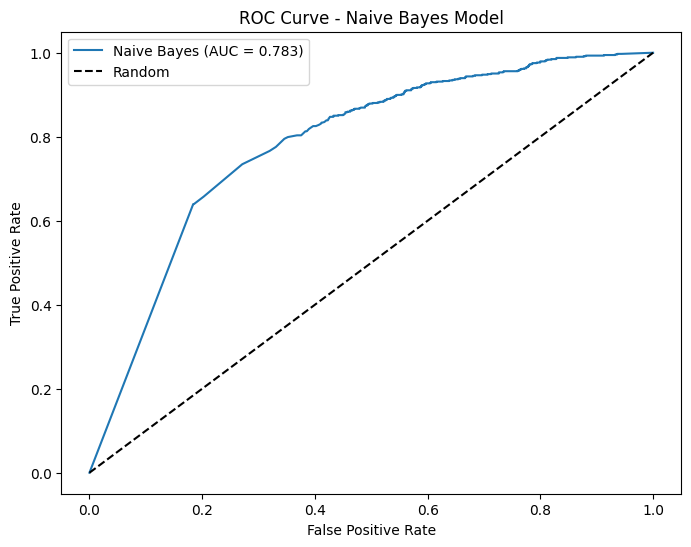

In [35]:
# Getting ROC data
fpr_NB, tpr_NB, _ = roc_curve(y_val, y_prob_NB)
auc_NB = roc_auc_score(y_val, y_prob_NB)

# Plotting ROC for the Logistic Regression model
plt.figure(figsize=(8,6))
plt.plot(fpr_NB, tpr_NB, label=f'Naive Bayes (AUC = {auc_NB:.3f})')
plt.plot([0,1], [0,1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Naive Bayes Model')
plt.legend()
plt.show()

In [16]:
logreg_model = make_pipeline(preprocessor, LogisticRegression())
logreg_model.fit(X_train, y_train)

,steps,"[('columntransformer', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [17]:
LogModelPrediction=logreg_model.predict(X_test)
Log_correct_prediction = np.sum(y_test==LogModelPrediction) #We check how many of the predicitions match the actual data
print(Log_correct_prediction/y_test.size)

0.8039728175640355


In [29]:
y_pred_log = logreg_model.predict(X_val)
y_prob_log = logreg_model.predict_proba(X_val)[:, 1]

print("\n=== Logistic Regression Evaluation ===")
print(classification_report(y_val, y_pred_log))

cmlog = confusion_matrix(y_val, y_pred_log)
print("Confusion matrix:\n", cmlog)



=== Logistic Regression Evaluation ===
              precision    recall  f1-score   support

           0       0.80      0.76      0.78       804
           1       0.75      0.79      0.77       727

    accuracy                           0.78      1531
   macro avg       0.78      0.78      0.78      1531
weighted avg       0.78      0.78      0.78      1531

Confusion matrix:
 [[611 193]
 [150 577]]


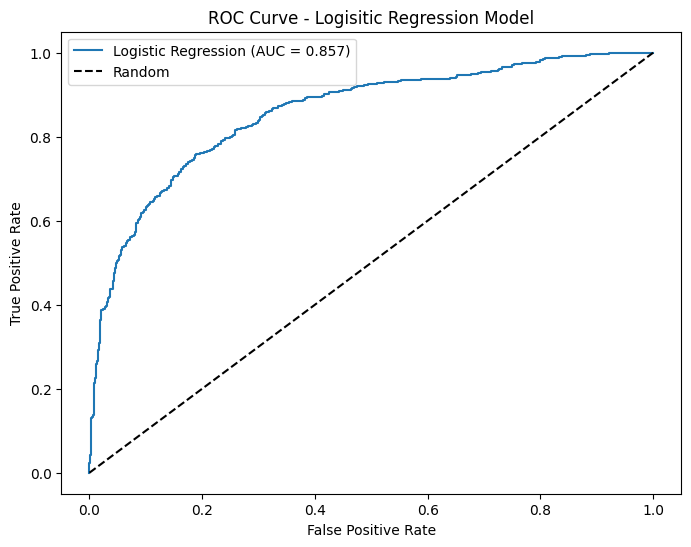

In [33]:
# Getting ROC data
fpr_log, tpr_log, _ = roc_curve(y_val, y_prob_log)
auc_log = roc_auc_score(y_val, y_prob_log)

# Plotting ROC for the Logistic Regression model
plt.figure(figsize=(8,6))
plt.plot(fpr_log, tpr_log, label=f'Logistic Regression (AUC = {auc_log:.3f})')
plt.plot([0,1], [0,1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logisitic Regression Model')
plt.legend()
plt.show()

In [23]:
# Create an SVM model: preprocess + model like before
SVM_model = make_pipeline(preprocessor, SVC(kernel='rbf', probability=True, random_state=42))

# Fit the model to the training data
SVM_model.fit(X_train, y_train)

# Make predictions
SVM_pred = SVM_model.predict(X_test)

In [24]:
SVM_correct_prediction = np.sum(y_test==SVM_pred) #We check how many of the predicitions match the actual data
print(SVM_correct_prediction/y_test.size)

0.8269733403031887


In [30]:
y_pred_SVM = SVM_model.predict(X_val)
y_prob_SVM = SVM_model.predict_proba(X_val)[:, 1]

print("\n=== SVM Evaluation ===")
print(classification_report(y_val, y_pred_SVM))

cmSVM = confusion_matrix(y_val, y_pred_SVM)
print("Confusion matrix:\n", cmSVM)


=== SVM Evaluation ===
              precision    recall  f1-score   support

           0       0.80      0.80      0.80       804
           1       0.78      0.78      0.78       727

    accuracy                           0.79      1531
   macro avg       0.79      0.79      0.79      1531
weighted avg       0.79      0.79      0.79      1531

Confusion matrix:
 [[643 161]
 [160 567]]


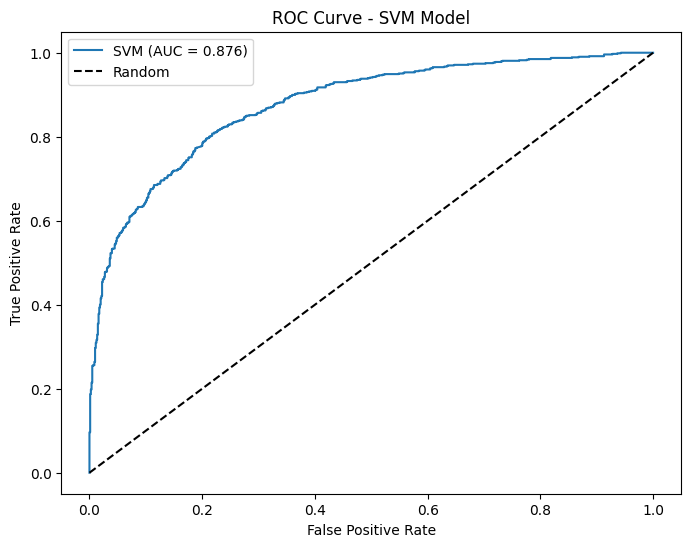

In [ ]:
# Get ROC data
fpr_SVM, tpr_SVM, _ = roc_curve(y_val, y_prob_SVM)
auc_SVM = roc_auc_score(y_val, y_prob_SVM)

# Plotting ROC for the SVM model
plt.figure(figsize=(8,6))
plt.plot(fpr_SVM, tpr_SVM, label=f'SVM (AUC = {auc_SVM:.3f})')
plt.plot([0,1], [0,1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM Model')
plt.legend()
plt.show()

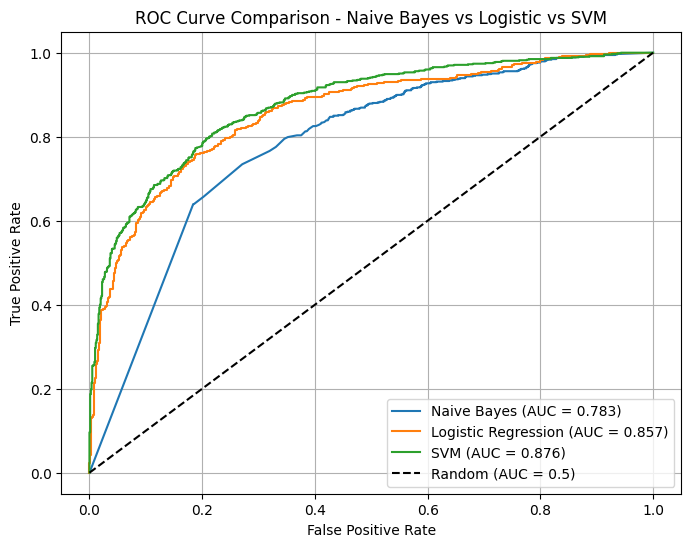

In [36]:
# All 3 ROC curves on same graph

plt.figure(figsize=(8,6))
plt.plot(fpr_NB, tpr_NB, label=f'Naive Bayes (AUC = {auc_NB:.3f})')
plt.plot(fpr_log, tpr_log, label=f'Logistic Regression (AUC = {auc_log:.3f})')
plt.plot(fpr_SVM, tpr_SVM, label=f'SVM (AUC = {auc_SVM:.3f})')
plt.plot([0,1], [0,1], 'k--', label='Random (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison - Naive Bayes vs Logistic vs SVM')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()